In [ ]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [8]:
import os
import shutil

# 設置路徑
original_dataset_dir = "/kaggle/input/animals10/raw-img"
working_dataset_dir = "/kaggle/working/raw-img"
test_dir = "/kaggle/working/test"

if os.path.exists(working_dataset_dir):
    shutil.rmtree(working_dataset_dir)

# 複製原始資料夾到工作資料夾
shutil.copytree(original_dataset_dir, working_dataset_dir)

# 創建測試資料夾
os.makedirs(test_dir, exist_ok=True)

num_test_images = 100

# 讀取每個類別的圖片並隨機選擇，並移動到測試資料夾
for class_name in os.listdir(working_dataset_dir):
    class_dir = os.path.join(working_dataset_dir, class_name)
    if os.path.isdir(class_dir):
        images = os.listdir(class_dir)
        test_images = random.sample(images, num_test_images)
        
        test_class_dir = os.path.join(test_dir, class_name)
        os.makedirs(test_class_dir, exist_ok=True)
        
        for image in test_images:
            src = os.path.join(class_dir, image)
            dst = os.path.join(test_class_dir, image)
            shutil.move(src, dst)


In [ ]:
# 瀏覽 /kaggle/working 目錄
for root, dirs, files in os.walk("/kaggle/working"):
    level = root.replace('/kaggle/working', '').count(os.sep)
    indent = ' ' * 4 * (level)
    print('{}{}/'.format(indent, os.path.basename(root)))
    subindent = ' ' * 4 * (level + 1)
    for f in files:
        print('{}{}'.format(subindent, f))

In [10]:
test_dir = "/kaggle/working/test"

for class_name in os.listdir(test_dir):
    class_dir = os.path.join(test_dir, class_name)
    if os.path.isdir(class_dir):
        num_images = len(os.listdir(class_dir))
        print(f"Class {class_name}: {num_images} images")

Class gallina: 100 images
Class mucca: 100 images
Class elefante: 100 images
Class gatto: 100 images
Class cane: 100 images
Class farfalla: 100 images
Class pecora: 100 images
Class cavallo: 101 images
Class scoiattolo: 100 images
Class ragno: 100 images


In [13]:
import tensorflow as tf 
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array

In [14]:
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
    
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

4863
73


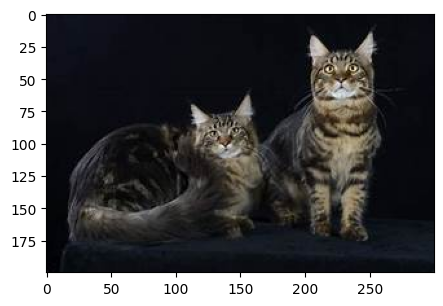

In [15]:
from glob import glob 
import cv2 

path_train = "/kaggle/input/animals10/raw-img/cane"
img = glob(path_train + "/*.jpeg")

print(len(img))
img = np.asarray(plt.imread(img[2]))

path_test = "/kaggle/working/test/gatto"
img_test = glob(path_test + "/*.jpeg")

print(len(img_test))
img_test = np.asarray(plt.imread(img_test[2]))


plt.figure(figsize = (5, 5))
plt.imshow(img)
plt.imshow(img_test)

In [17]:
img_size = 128 
batch_size = 32
num_classes = 10
directory = working_dataset_dir
test_dir = '/kaggle/working/test'

# 訓練集影像增強
traingen = ImageDataGenerator(rescale=1/255.,
                              rotation_range=10,                    # 隨機旋轉圖像0 ~ 10度
                              width_shift_range=0.1,                # 隨機水平平移圖像10%
                              height_shift_range=0.1,               # 隨機垂直平移圖像10%
                              shear_range=0.1,                      # 隨機剪切變換圖像0.1
                              zoom_range=0.1,                       # 隨機縮放圖像0.9 ~ 1.1
                              horizontal_flip=True,                 # 隨機水平翻轉圖像
                              fill_mode='nearest',                  # 最接近的像素值填充
                              #brightness_range=[0.9, 1.1],  
                              validation_split=0.2                  # 切分驗證集
                              )


testgen = ImageDataGenerator(rescale=1/255.)


traindata = traingen.flow_from_directory(directory,
                                       target_size = (img_size,img_size)
                                       ,batch_size = batch_size,
                                       shuffle = True,class_mode = 'categorical',
                                      subset = 'training')


valdata = traingen.flow_from_directory(directory,
                                    shuffle = False, batch_size = batch_size,
                                    target_size = (img_size,img_size),
                                    class_mode = "categorical",subset = 'validation')

# 準備測試集
testdata = testgen.flow_from_directory(test_dir,
                                       target_size=(img_size, img_size),
                                       batch_size=batch_size,
                                       shuffle=False,
                                       class_mode='categorical')



Found 20147 images belonging to 10 classes.
Found 5032 images belonging to 10 classes.
Found 1001 images belonging to 10 classes.


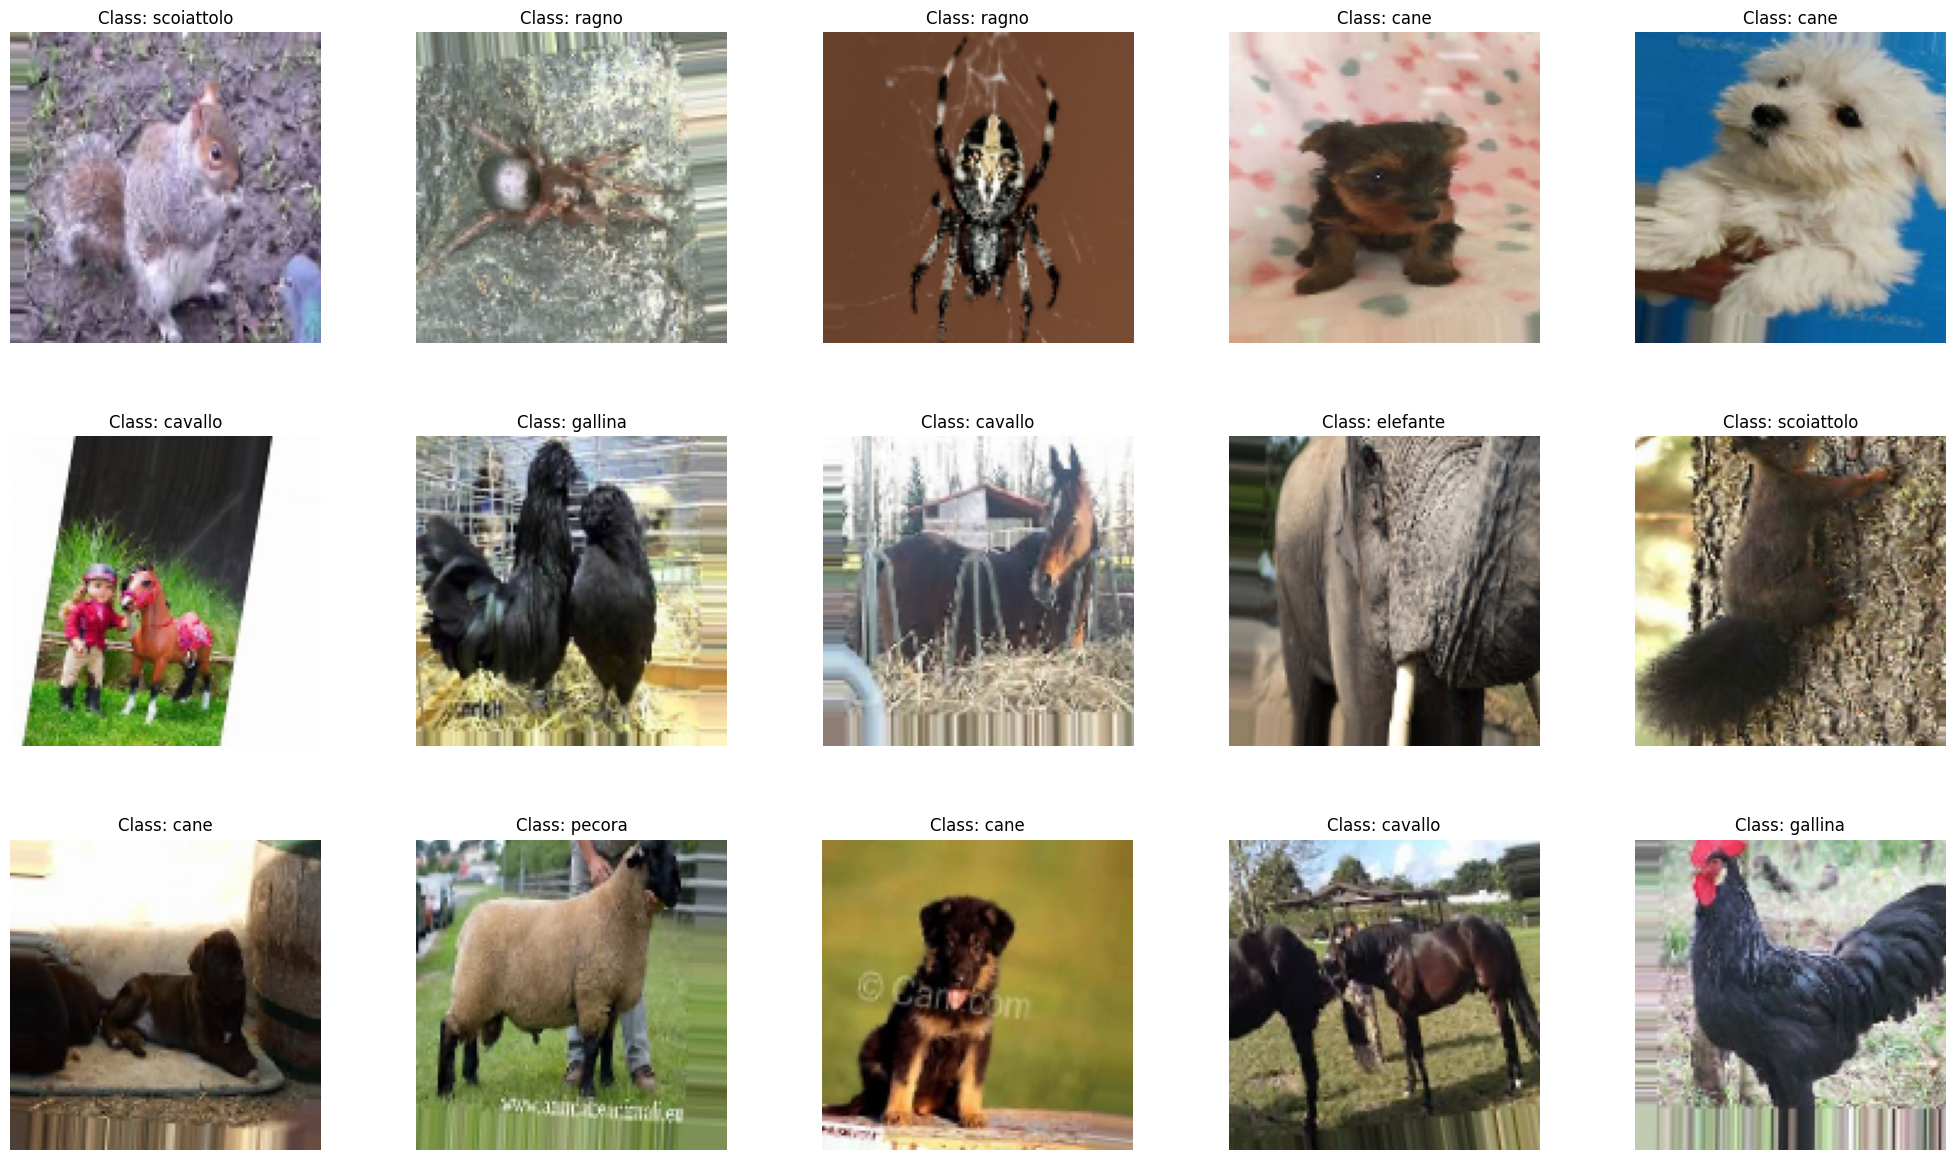

In [18]:
labels = [key for key in traindata.class_indices] 
samples = traindata.__next__()
images = samples[0]
target = samples[1]
plt.rcParams['figure.figsize'] = (25,25)

for i in range(15):
    plt.subplot(5,5,i+1)
    plt.subplots_adjust(hspace = 0.3,wspace = .3)
    plt.imshow(images[i])
    plt.title(f"Class: {labels[np.argmax(target[i],axis = 0)]}")
    plt.axis('off')

In [19]:
# 建立CNN模型
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2

model = Sequential([
    Input(shape=(img_size, img_size, 3)),
    
    #1
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    #2
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)), 

    #3
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    #4
    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),  # 增加一個卷積層
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,114,570 (19.51 MB)

 Trainable params: 5,113,610 (19.51 MB)

 Non-trainable params: 960 (3.75 KB)

In [20]:
# 編譯模型
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 設置回調
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)


In [21]:
# Training Model 

history = model.fit(
    traindata,
    validation_data = valdata,
    epochs = 40,
    callbacks = [early_stopping, reduce_lr]
)

Epoch 1/40


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/630 ━━━━━━━━━━━━━━━━━━━━ 2:21:22 13s/step - accuracy: 0.1875 - loss: 5.4219

I0000 00:00:1717774068.968819     217 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717774068.990727     217 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


531/630 ━━━━━━━━━━━━━━━━━━━━ 17s 175ms/step - accuracy: 0.3086 - loss: 3.6338

W0000 00:00:1717774161.829478     217 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


629/630 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.3194 - loss: 3.5641

W0000 00:00:1717774177.500918     216 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


630/630 ━━━━━━━━━━━━━━━━━━━━ 144s 208ms/step - accuracy: 0.3196 - loss: 3.5628 - val_accuracy: 0.4686 - val_loss: 2.8060 - learning_rate: 1.0000e-04
Epoch 2/40


W0000 00:00:1717774199.514387     217 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


630/630 ━━━━━━━━━━━━━━━━━━━━ 115s 181ms/step - accuracy: 0.4722 - loss: 2.7782 - val_accuracy: 0.5684 - val_loss: 2.4691 - learning_rate: 1.0000e-04
Epoch 3/40
630/630 ━━━━━━━━━━━━━━━━━━━━ 114s 180ms/step - accuracy: 0.5316 - loss: 2.5568 - val_accuracy: 0.5811 - val_loss: 2.3670 - learning_rate: 1.0000e-04
Epoch 4/40
630/630 ━━━━━━━━━━━━━━━━━━━━ 116s 182ms/step - accuracy: 0.5639 - loss: 2.3997 - val_accuracy: 0.6198 - val_loss: 2.1554 - learning_rate: 1.0000e-04
Epoch 5/40
630/630 ━━━━━━━━━━━━━━━━━━━━ 116s 182ms/step - accuracy: 0.5947 - loss: 2.2538 - val_accuracy: 0.6180 - val_loss: 2.1077 - learning_rate: 1.0000e-04
Epoch 6/40
630/630 ━━━━━━━━━━━━━━━━━━━━ 114s 180ms/step - accuracy: 0.6101 - loss: 2.1115 - val_accuracy: 0.6290 - val_loss: 2.0143 - learning_rate: 1.0000e-04
Epoch 7/40
630/630 ━━━━━━━━━━━━━━━━━━━━ 114s 179ms/step - accuracy: 0.6304 - loss: 1.9934 - val_accuracy: 0.6663 - val_loss: 1.8304 - learning_rate: 1.0000e-04
Epoch 8/40
630/630 ━━━━━━━━━━━━━━━━━━━━ 114s 180ms/

In [22]:
# 評估模型(驗證)
val_loss, val_accuracy = model.evaluate(valdata)
print(f'Validation accuracy: {val_accuracy}')

# 評估模型(測試)
test_loss, test_accuracy = model.evaluate(testdata)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

158/158 ━━━━━━━━━━━━━━━━━━━━ 22s 138ms/step - accuracy: 0.8297 - loss: 1.0602
Validation accuracy: 0.8199523091316223
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.7386 - loss: 1.4251
Test Loss: 1.4080326557159424
Test Accuracy: 0.7432567477226257


W0000 00:00:1717779212.412750     218 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


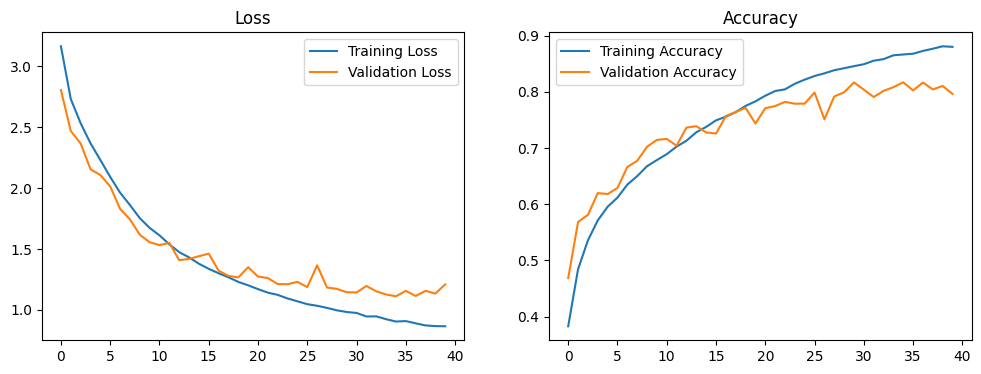

In [23]:
# 顯示訓練過程中的loss和準確度變化
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.legend()
plt.title('Loss')
plt.subplot(1, 2, 2)

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.legend()
plt.title('Accuracy')
plt.show()

In [24]:
# Confusion Matrix 評估
from sklearn.metrics import classification_report, confusion_matrix

label = [k for k in traindata.class_indices]

y_test = testdata.classes
y_pred = model.predict(testdata)
y_pred = np.argmax(y_pred,axis=1)

print(classification_report(y_test,y_pred,target_names = label))

 8/32 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

W0000 00:00:1717779286.030116     217 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step
              precision    recall  f1-score   support

        cane       0.70      0.65      0.67       100
     cavallo       0.75      0.78      0.77       101
    elefante       0.58      0.90      0.70       100
    farfalla       0.79      0.95      0.86       100
     gallina       0.75      0.79      0.77       100
       gatto       0.98      0.47      0.64       100
       mucca       0.84      0.57      0.68       100
      pecora       0.79      0.71      0.75       100
       ragno       0.72      0.86      0.78       100
  scoiattolo       0.79      0.75      0.77       100

    accuracy                           0.74      1001
   macro avg       0.77      0.74      0.74      1001
weighted avg       0.77      0.74      0.74      1001



W0000 00:00:1717779288.043018     217 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [25]:
#1
#2
#model.save('animal_0607(2)_model')
model.save('animal_0607(4)_model.h5')